In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run ../lstm_optimizer_drop.py

In [3]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', lambd=1e-5, **kwargs):
        n_steps = T.iscalar()
        
        l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
        self.l_optim = LSTMOptimizerLayer(l_input, n_steps=n_steps, function=func, **kwargs)
        
        self.params_init = L.layers.get_all_param_values(self.l_optim)

        theta_history, loss_history, scan_updates = L.layers.get_output(self.l_optim)

        self.loss_type = loss_type
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = T.log(loss_history).sum()
        elif loss_type == 'weighted_prod':
            loss = (T.log(loss_history) * 0.9**T.arange(loss_history.shape[0])[::-1]).sum()
                
        loss += lambd * L.regularization.regularize_network_params(self.l_optim, L.regularization.l2)
                
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        updates.update(scan_updates)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True, updates=scan_updates)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
        theta_history_det, loss_history_det, scan_updates_det = L.layers.get_output(self.l_optim, deterministic=True)
        self.loss_det_fn = theano.function([input_var, n_steps] + func_params, [theta_history_det, loss_history_det], allow_input_downcast=True, updates=scan_updates_det)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.l_optim, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        optimizer_loss = []
        optimizer_moving_loss = []
        moving_loss = None

#         fig = plt.figure(figsize=(15, 12))
        
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                if self.loss_type == 'sum':
                    loss = np.sum(loss_history)
                else:
                    loss = np.sum(np.log(loss_history))
                training_loss_history.append(loss_history)
            
                optimizer_loss.append(loss)
                if moving_loss is None:
                    moving_loss = loss
                else:
                    moving_loss = 0.9 * moving_loss + 0.1 * loss
                optimizer_moving_loss.append(moving_loss)

            display.clear_output(wait=True)
#             fig.clear()
            
#             ax = fig.add_subplot(2, 1, 2)
#             ax.semilogy(np.median(training_loss_history, axis=0))
#             #plt.subplot(2, 1, 2)
            #plt.semilogy(np.median(training_loss_history, axis=0))

#             ax = fig.add_subplot(2, 1, 1)
            #plt.subplot(2, 1, 1)
#             if self.loss_type == 'sum':
#                 ax.semilogy(optimizer_loss, 'b', label='loss')
#                 ax.semilogy(optimizer_moving_loss, 'r', label='moving loss')
#                 #plt.semilogy(optimizer_loss, 'b', label='loss')
#                 #plt.semilogy(optimizer_moving_loss, 'r', label='moving loss')
#             else:
#                 ax.plot(optimizer_loss, 'b', label='loss')
#                 ax.plot(optimizer_moving_loss, 'r', label='moving loss')
#                 #plt.plot(optimizer_loss, 'b', label='loss')
#                 #plt.plot(optimizer_moving_loss, 'r', label='moving loss')

#             fig.canvas.draw()
#             #plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [4]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [5]:
class DiagFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.vector('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((self.W * self.theta - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [6]:
W = T.matrix()
b = T.vector()
    
w = T.vector()
    
func = lambda theta: QuadraticFunction(theta, W, b).func
# func = lambda theta: DiagFunction(theta, w, b).func

In [7]:
input_var = T.vector()

In [8]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)
# sgd_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [9]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

# momentum_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
#         momentum_mu: np.cast['float32'](0.9),
#     })

In [10]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
    'preprocess_input': False,
    
    'p_drop_grad': 0.0,
    'p_drop_delta': 0.0,
    'fix_drop_delta_over_time': True,
    'fix_drop_grad_over_time': True,
    
    'loss_type': 'sum',
}

for n_gac in [0, 5]:
    for p_drop_coord in [0.0, 0.5]:
        for fix in [False, True]:
            if p_drop_coord == 0.0 and not fix:
                continue
            
            options['n_gac'] = n_gac
            options['p_drop_coord'] = p_drop_coord
            options['fix_drop_coord_over_time'] = fix

            key = "n_gac={}; p_drop_coord={}; fix={}".format(n_gac, p_drop_coord, fix)
            if options.get(key, None) is None:
                lstm_optimizers[key] = LSTMOptimizer(input_var, func, [W, b], **options)
                print(key)

n_gac=0; p_drop_coord=0.0; fix=True
n_gac=0; p_drop_coord=0.5; fix=False
n_gac=0; p_drop_coord=0.5; fix=True
n_gac=5; p_drop_coord=0.0; fix=True
n_gac=5; p_drop_coord=0.5; fix=False
n_gac=5; p_drop_coord=0.5; fix=True


In [11]:
def sample_params(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.random.randn(ndim, ndim))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point(ndim):
    theta = np.cast['float32'](np.random.randn(ndim))
    return theta

def sample_point_and_params(ndim=None):
    W, b = sample_params(ndim)
    theta = sample_point(len(b))
    
    return theta, (W, b)

def sample_params_diag(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.diag(np.random.randn(ndim)))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point_and_params_diag(ndim=10):
    W, b = sample_params_diag(ndim)
    theta = sample_point(len(b))
    
    return theta, (np.diag(W), b)

# data = [sample_point_and_params(ndim=10) for _ in range(5000)]
# data = [sample_point_and_params_diag(100) for _ in range(5000)]
# np.random.shuffle(data)
# data_index = 0

# def sample_from_data():
#     global data_index
#     theta, (W_, b_) = data[data_index]
#     data_index = (data_index + 1) % len(data)
#     return theta, (W_, b_)

In [ ]:
training_options = {
    'n_iter': 100,
    'n_epochs': 50,
    'batch_size': 100,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    opt.reset_network()
    opt.lr.set_value(0.01)

    if key.find('p_drop_coord=0.0') != -1:
        sampler = sample_point_and_params
    else:
        sampler = lambda: sample_point_and_params(ndim=50)
    
    for n_iter in [20, 40, 60]:
        training_options['n_iter'] = n_iter
        opt.train(sampler, **training_options)

Epoch number 11
Time on epoch 11: 3.190781354904175
Loss on 11: 165.09570381045341; 0.39747023582458496


In [17]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [15]:
def test_optimizers(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history

    return histories

In [ ]:
testing_options = {
    'n_iter': 60,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_60 = test_optimizers(**testing_options)

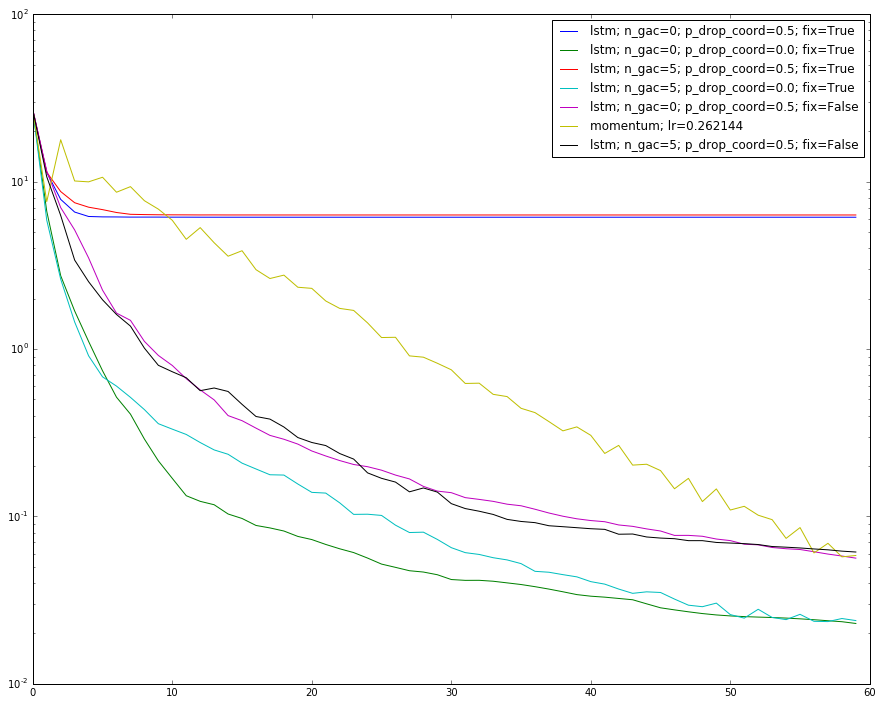

In [34]:
plt.figure(figsize=(15, 12))
for name, hist in histories_60.items():
    linestyle = 'solid'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories = test_optimizers(**testing_options)

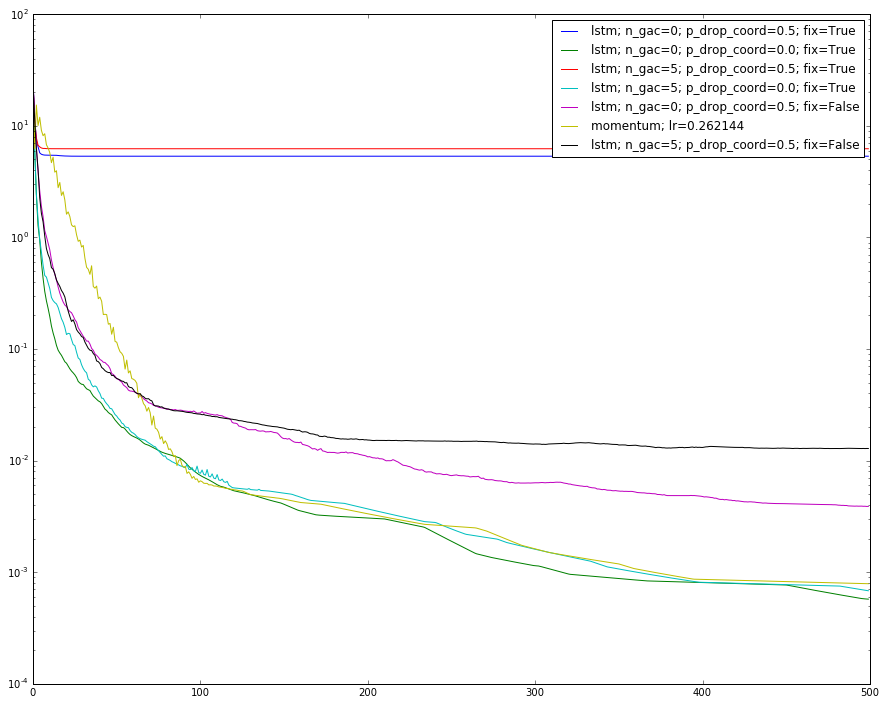

In [36]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = 'solid'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
import itertools

generalization_loss_lstm = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 50), range(900, 950)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm[name].append(np.mean(losses))

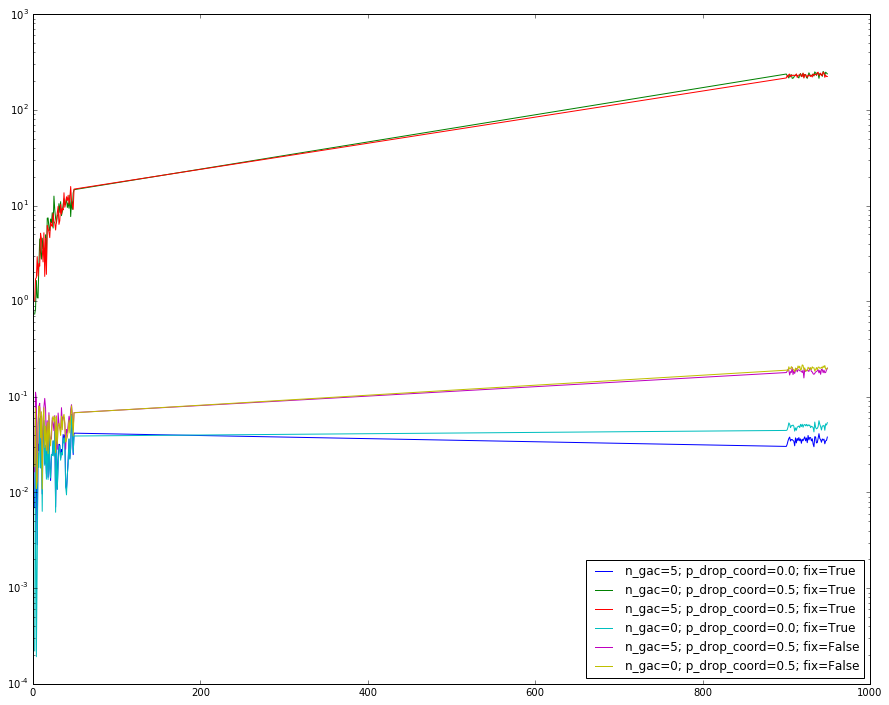

In [37]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(list(range(2, 50)) + list(range(900, 950)), losses[:], label=name)
plt.legend(loc=4);

In [69]:
for name, opt in lstm_optimizers.items():
    with open('quadratic_optimizer_drop_coord({}).npz'.format(name), 'wb') as f:
        np.savez(f, L.layers.get_all_param_values(opt.l_optim))

In [30]:
import theano.sandbox.cuda.basic_ops as sbcuda
print(sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]/1024./1024/1024)

5.101543426513672


In [13]:
for name, opt in lstm_optimizers.items():
    with np.load('final_good_drop_quadratic_optimizer_with_no_error_2({}).npz'.format(name)) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    L.layers.set_all_param_values(opt.l_optim, param_values[0])

In [14]:
def test_optimizers_det(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.loss_det_fn(theta, testing_options['n_iter'], W_, b_)[1])
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history
    return histories

In [ ]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_det = test_optimizers_det(**testing_options)

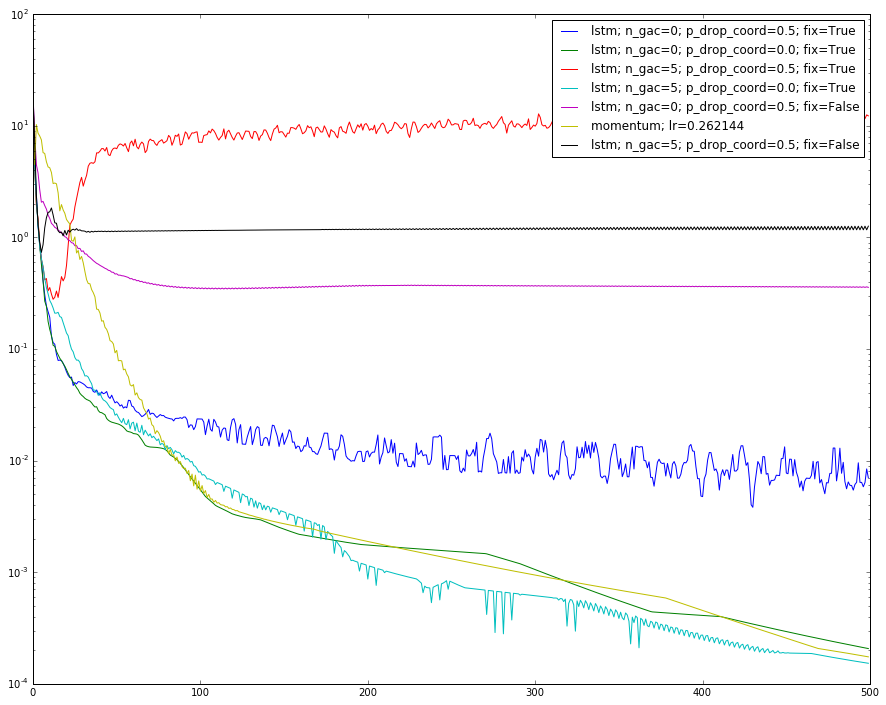

In [39]:
plt.figure(figsize=(15, 12))
for name, hist in histories_det.items():
    linestyle = 'solid'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
import itertools

generalization_loss_lstm_2 = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 150), range(900, 1000)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm_2[name].append(np.mean(losses))

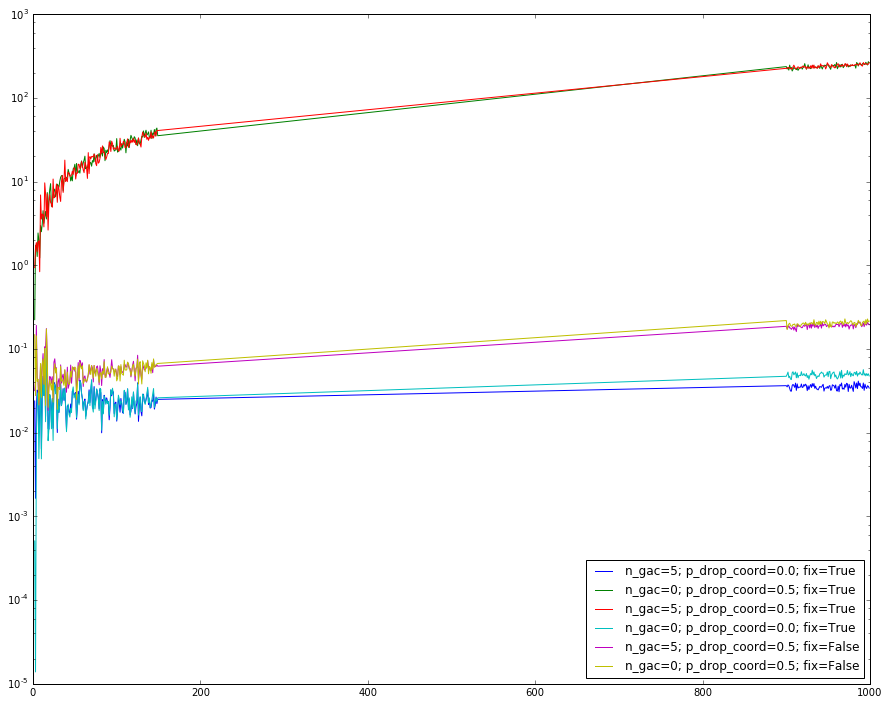

In [40]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(2, 150)) + list(range(900, 1000)), losses[:], label=name)
plt.legend(loc=4);

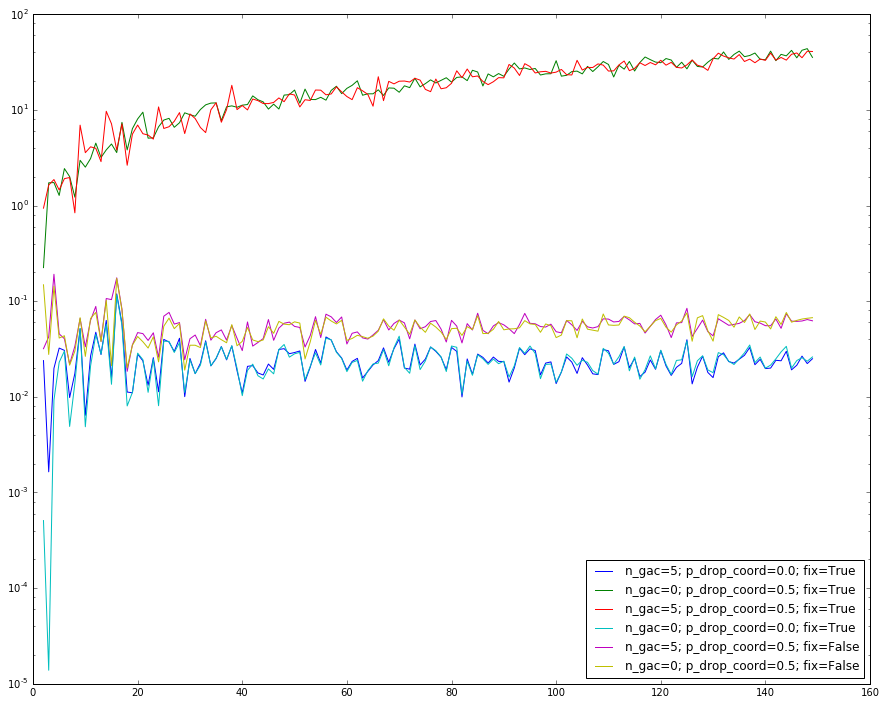

In [41]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(2, 150)), losses[:148], label=name)
plt.legend(loc=4);

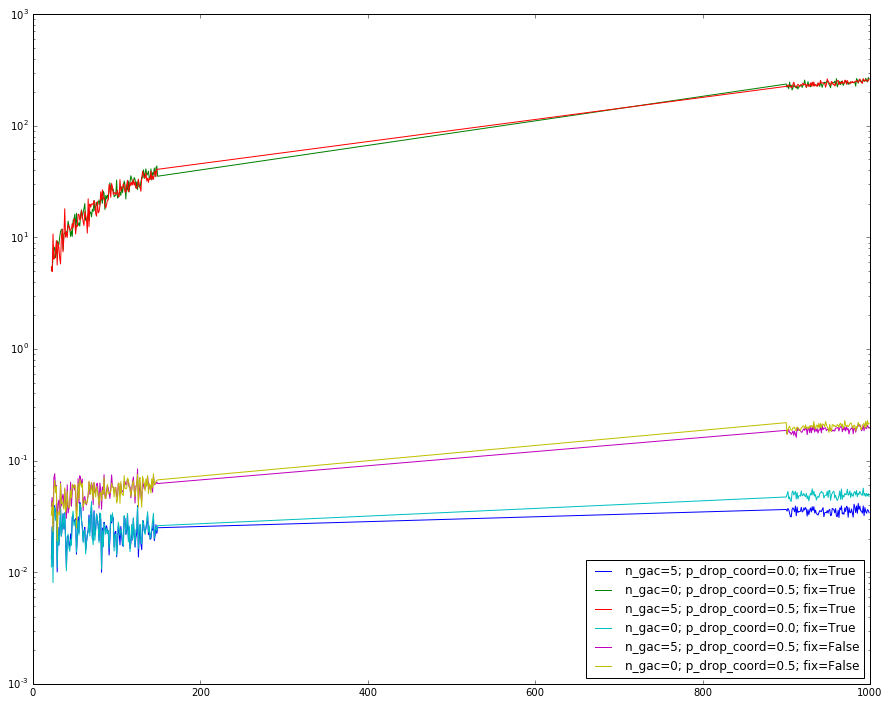

In [42]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(22, 150)) + list(range(900, 1000)), losses[20:], label=name)
plt.legend(loc=4);

In [50]:
def test_optimizers_both(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        loss_history_det = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
            loss_history_det.append(opt.loss_det_fn(theta, testing_options['n_iter'], W_, b_)[1])
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)
        histories['lstm_det; {}'.format(key)] = np.median(loss_history_det, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history
    return histories

In [51]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_both = test_optimizers_both(**testing_options)

Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing momentum


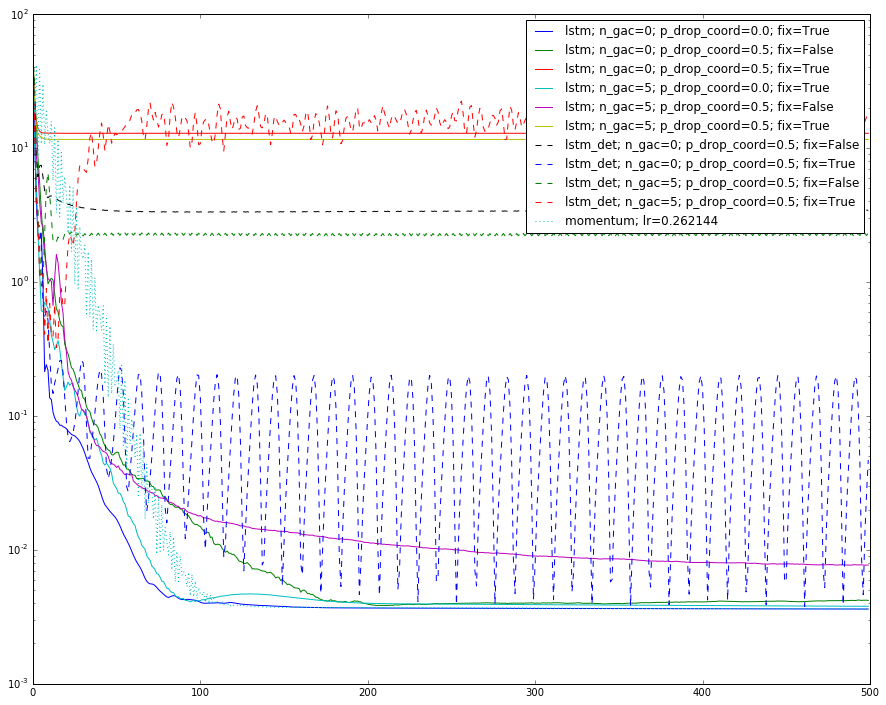

In [57]:
plt.figure(figsize=(15, 12))
for name, hist in sorted(histories_both.items()):
    
    if name.find('det') != -1 and name.find('0.0') != -1:
        continue
    
    linestyle = 'solid'
    if name.find('det') != -1:
        linestyle = '--'
    
    if name.find('momentum') != -1:
        linestyle = 'dotted'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [53]:
testing_options = {
    'n_iter': 500,
    'n_functions': 1,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_both = test_optimizers_both(**testing_options)

Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing momentum


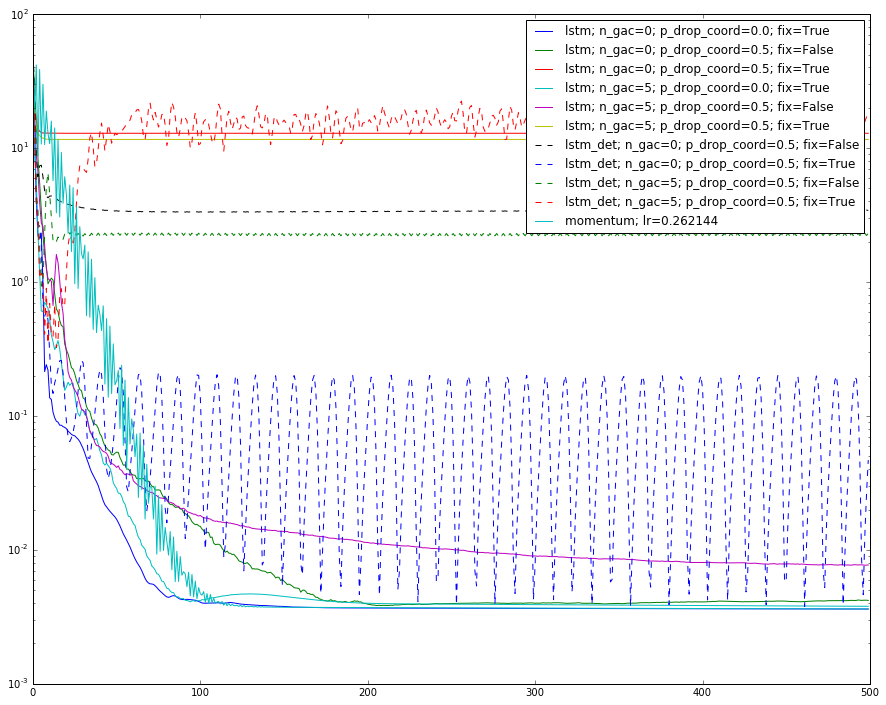

In [54]:
plt.figure(figsize=(15, 12))
for name, hist in sorted(histories_both.items()):
    
    if name.find('det') != -1 and name.find('0.0') != -1:
        continue
    
    linestyle = 'solid'
    if name.find('det') != -1:
        linestyle = '--'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [73]:
import itertools
import time

generalization_loss_lstm_det = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 50), range(900, 1000)):
    t = time.time()
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.loss_det_fn(theta, 100, W_, b_)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm_det[name].append(np.mean(losses))
        
    print("Time: {}".format(time.time() - t))

2
Time: 3.8140249252319336
3
Time: 3.3013834953308105
4
Time: 3.3084375858306885
5
Time: 3.383479118347168
6
Time: 3.3592751026153564
7
Time: 3.3229494094848633
8
Time: 3.184861898422241
9
Time: 3.212338924407959
10
Time: 3.2054829597473145
11
Time: 3.1926703453063965
12
Time: 3.287163734436035
13
Time: 3.349048137664795
14
Time: 3.2187275886535645
15
Time: 3.297574996948242
16
Time: 3.4331769943237305
17
Time: 3.419062376022339
18
Time: 3.3291289806365967
19
Time: 3.293208122253418
20
Time: 3.34572434425354
21
Time: 4.014730453491211
22
Time: 3.4583206176757812
23
Time: 3.4820401668548584
24
Time: 4.05058217048645
25
Time: 3.2412004470825195
26
Time: 3.2112274169921875
27
Time: 3.2266533374786377
28
Time: 3.230437994003296
29
Time: 3.383028030395508
30
Time: 3.4093384742736816
31
Time: 3.3903684616088867
32
Time: 3.0704267024993896
33
Time: 3.2276971340179443
34
Time: 3.249831199645996
35
Time: 3.365833282470703
36
Time: 3.331913709640503
37
Time: 3.284467935562134
38
Time: 3.28945374

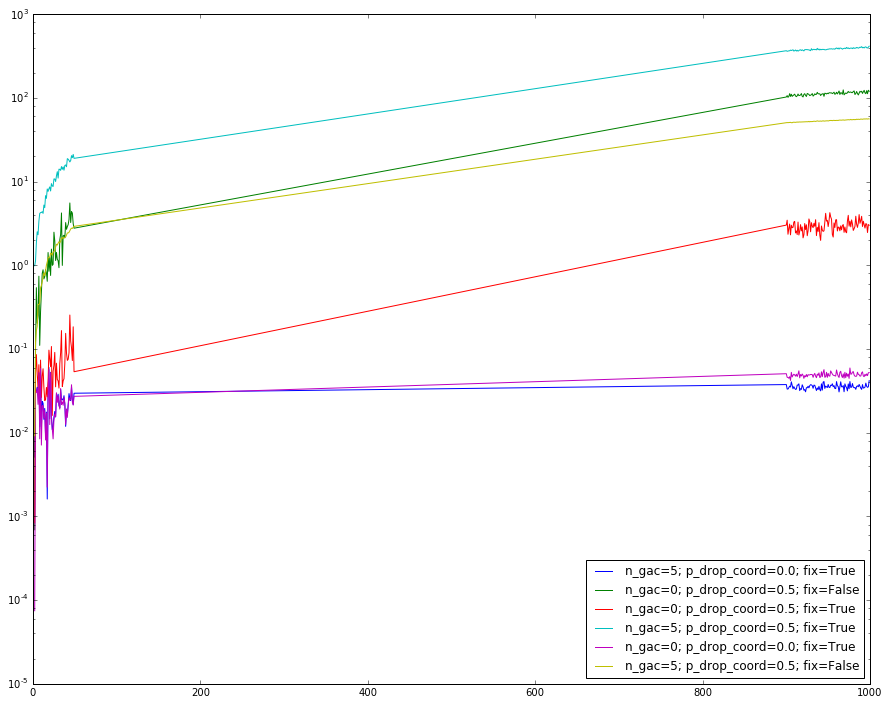

In [74]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_det.items():
    plt.semilogy(list(range(2, 50)) + list(range(900, 1000)), losses, label=name)
plt.legend(loc=4);

In [18]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_2 = test_optimizers(**testing_options)

Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing momentum


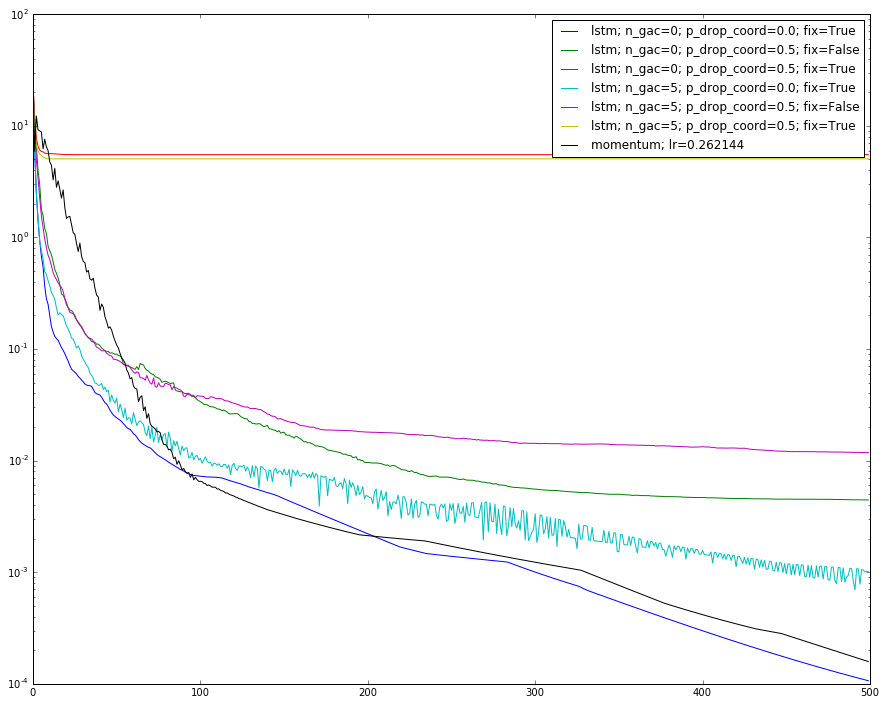

In [20]:
plt.figure(figsize=(15, 12))
for name, hist in sorted(histories_2.items()):
    linestyle = 'solid'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_det_2 = test_optimizers_det(**testing_options)

Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing momentum


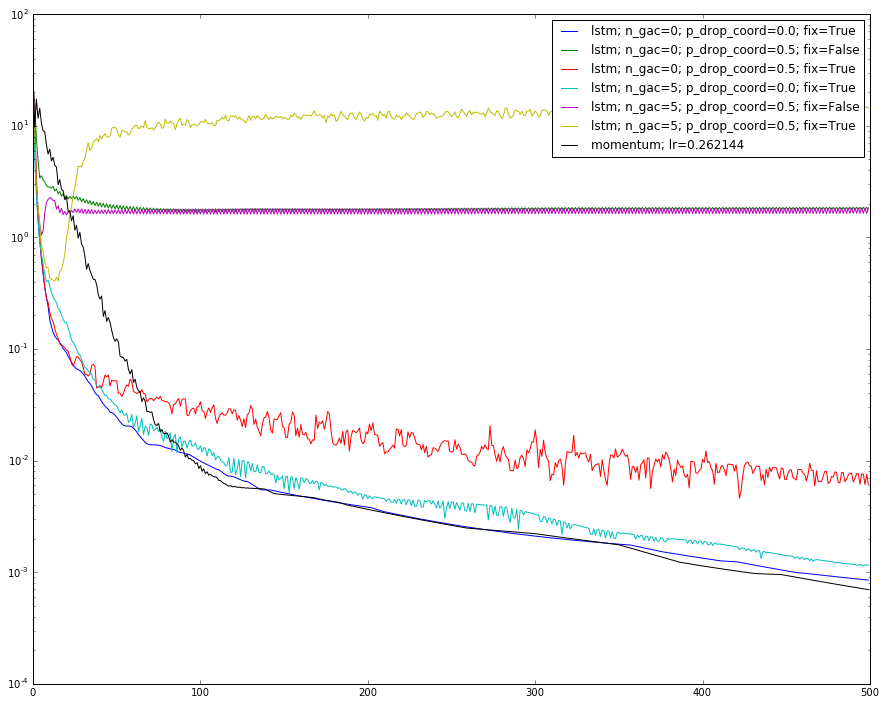

In [24]:
plt.figure(figsize=(15, 12))
for name, hist in sorted(histories_det_2.items()):
    linestyle = 'solid'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [48]:
theta, (W_, b_) = sample_point_and_params(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)
    
    history, losses = opt.loss_det_fn(theta, 300, W_, b_)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name+'_det'] = (history, losses)


sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 0.262144)

[ 0.38023433  1.04658449]


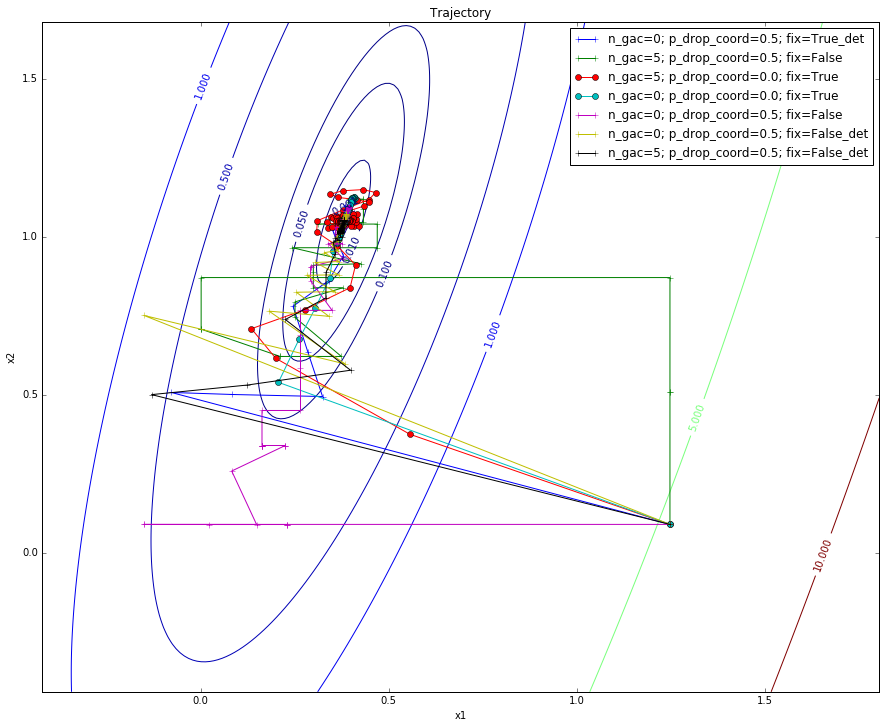

In [65]:
theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in sample_runs:
    history, lss = sample_runs[name]
    if lss[-1] > 0.1 or name == 'momentum':#or name.find('fix=False') == -1:
        continue
    if name.find('0.0') == -1:
        marker = '+'
    elif name.find('det') != -1:
        continue
    else:
        marker = 'o'
    plt.plot(history.T[0], history.T[1], marker=marker, label=name)

# history, _ = sample_runs['momentum']
# plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

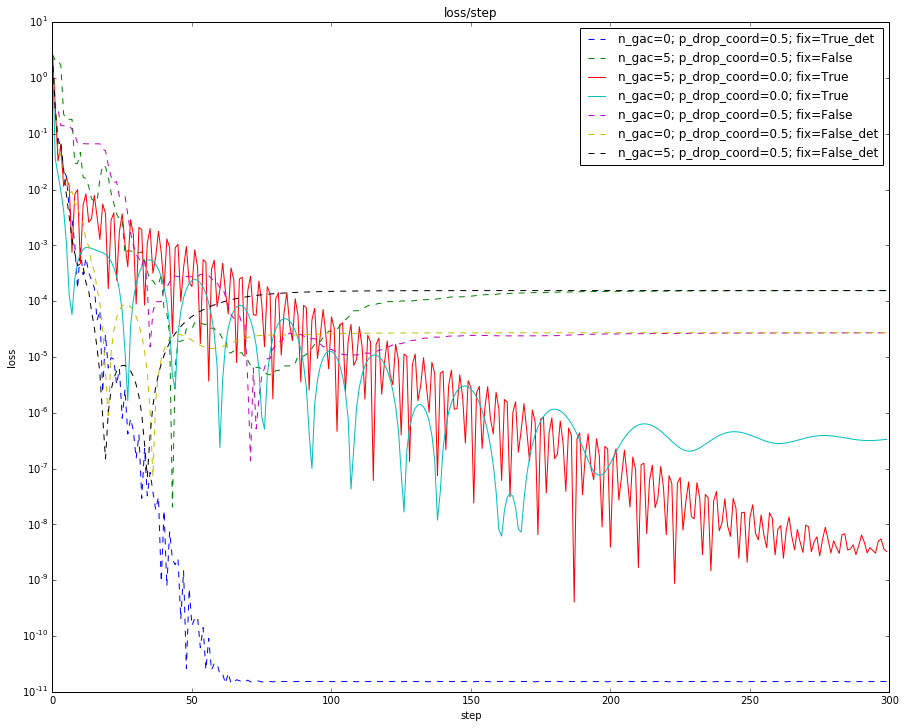

In [68]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in sample_runs:
    _, losses = sample_runs[name]
    if losses[-1] > 0.1 or name == 'momentum':#or name.find('fix=False') == -1:
        continue

    linestyle = 'solid'
    if name.find('0.0') == -1:
        linestyle = '--'
    elif name.find('det') != -1:
        continue
        
    plt.semilogy(losses, label=name, linestyle=linestyle)

# _, losses = sample_runs['momentum']    
# plt.semilogy(losses, label='momentum', linestyle='--')
plt.legend();

In [70]:
import pickle

In [76]:
with open('gen_loss_lstm_det_15000', 'wb') as f:
    pickle.dump(generalization_loss_lstm_det, f)

In [77]:
with open('gen_loss_lstm_det_30000', 'rb') as f:
    generalization_loss_lstm_det2 = pickle.load(f)

In [78]:
with open('gen_loss_lstm_det_60000', 'rb') as f:
    generalization_loss_lstm_det3 = pickle.load(f)

In [79]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_det.items():
    plt.semilogy(list(range(2, 50)) + list(range(900, 1000)), losses, label=name+"_15000", linestyle='solid')
    plt.semilogy(list(range(2, 50)) + list(range(900, 1000)), generalization_loss_lstm_det2[name], label=name+"_30000", linestyle='dashed')
    plt.semilogy(list(range(2, 50)) + list(range(900, 1000)), generalization_loss_lstm_det3[name], label=name+"_60000", linestyle='-.')
plt.legend(loc=4);

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc0f84df488> (for post_execute):


OSError: [Errno 24] Too many open files: '/home/yanushv/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/Vera.ttf'

OSError: [Errno 24] Too many open files: '/home/yanushv/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/Vera.ttf'